In [21]:
import pathlib
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from scipy.stats import binned_statistic, binned_statistic_2d, circmean, circstd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def circmean_hour(x):
    return circmean(x, high=24, low=0)

def circstd_hour(x):
    return circstd(x, high=24, low=0)

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600


In [2]:
data_path = pathlib.Path("/work/scratch-nopw2/wkjones/seviri_statistics/")
files = sorted(list(data_path.glob("*.nc")))

In [3]:
datasets = [xr.open_dataset(f) for f in files]

In [4]:
np.sum([ds.core.size for ds in datasets]), np.sum([ds.anvil.size for ds in datasets])

(94189, 44194)

In [5]:
core_start_lat = np.concatenate([ds.core_start_lat.data for ds in datasets])
core_start_lon = np.concatenate([ds.core_start_lon.data for ds in datasets])
core_start_t = np.concatenate([ds.core_start_t.data for ds in datasets])

# Now calculate local (solar) time using latitude
core_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=core_start_lon[i]/15)).time() for i,t in enumerate(core_start_t)])

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

core_local_hour = np.array([get_fractional_hour(t) for t in core_local_time])

In [6]:
anvil_start_lat = np.concatenate([ds.thick_anvil_start_lat.data for ds in datasets])
anvil_start_lon = np.concatenate([ds.thick_anvil_start_lon.data for ds in datasets])
anvil_start_t = np.concatenate([ds.thick_anvil_start_t.data for ds in datasets])

# Now calculate local (solar) time using latitude
anvil_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=anvil_start_lon[i]/15)).time() for i,t in enumerate(anvil_start_t)])

anvil_local_hour = np.array([get_fractional_hour(t) for t in anvil_local_time])

In [7]:
anvil_is_valid = np.concatenate([ds.thick_anvil_is_valid.data for ds in datasets])
np.sum(anvil_is_valid), anvil_is_valid.size

(41265, 44194)

/tmp/ipykernel_40392/1097770287.py:70: RuntimeWarning: divide by zero encountered in divide
  )[0] * (h[0]/(h[0]-1))
/tmp/ipykernel_40392/1097770287.py:65: RuntimeWarning: invalid value encountered in multiply
  hatch_data = binned_statistic_2d(


Text(0.5, 1.0, 'Core detection time')

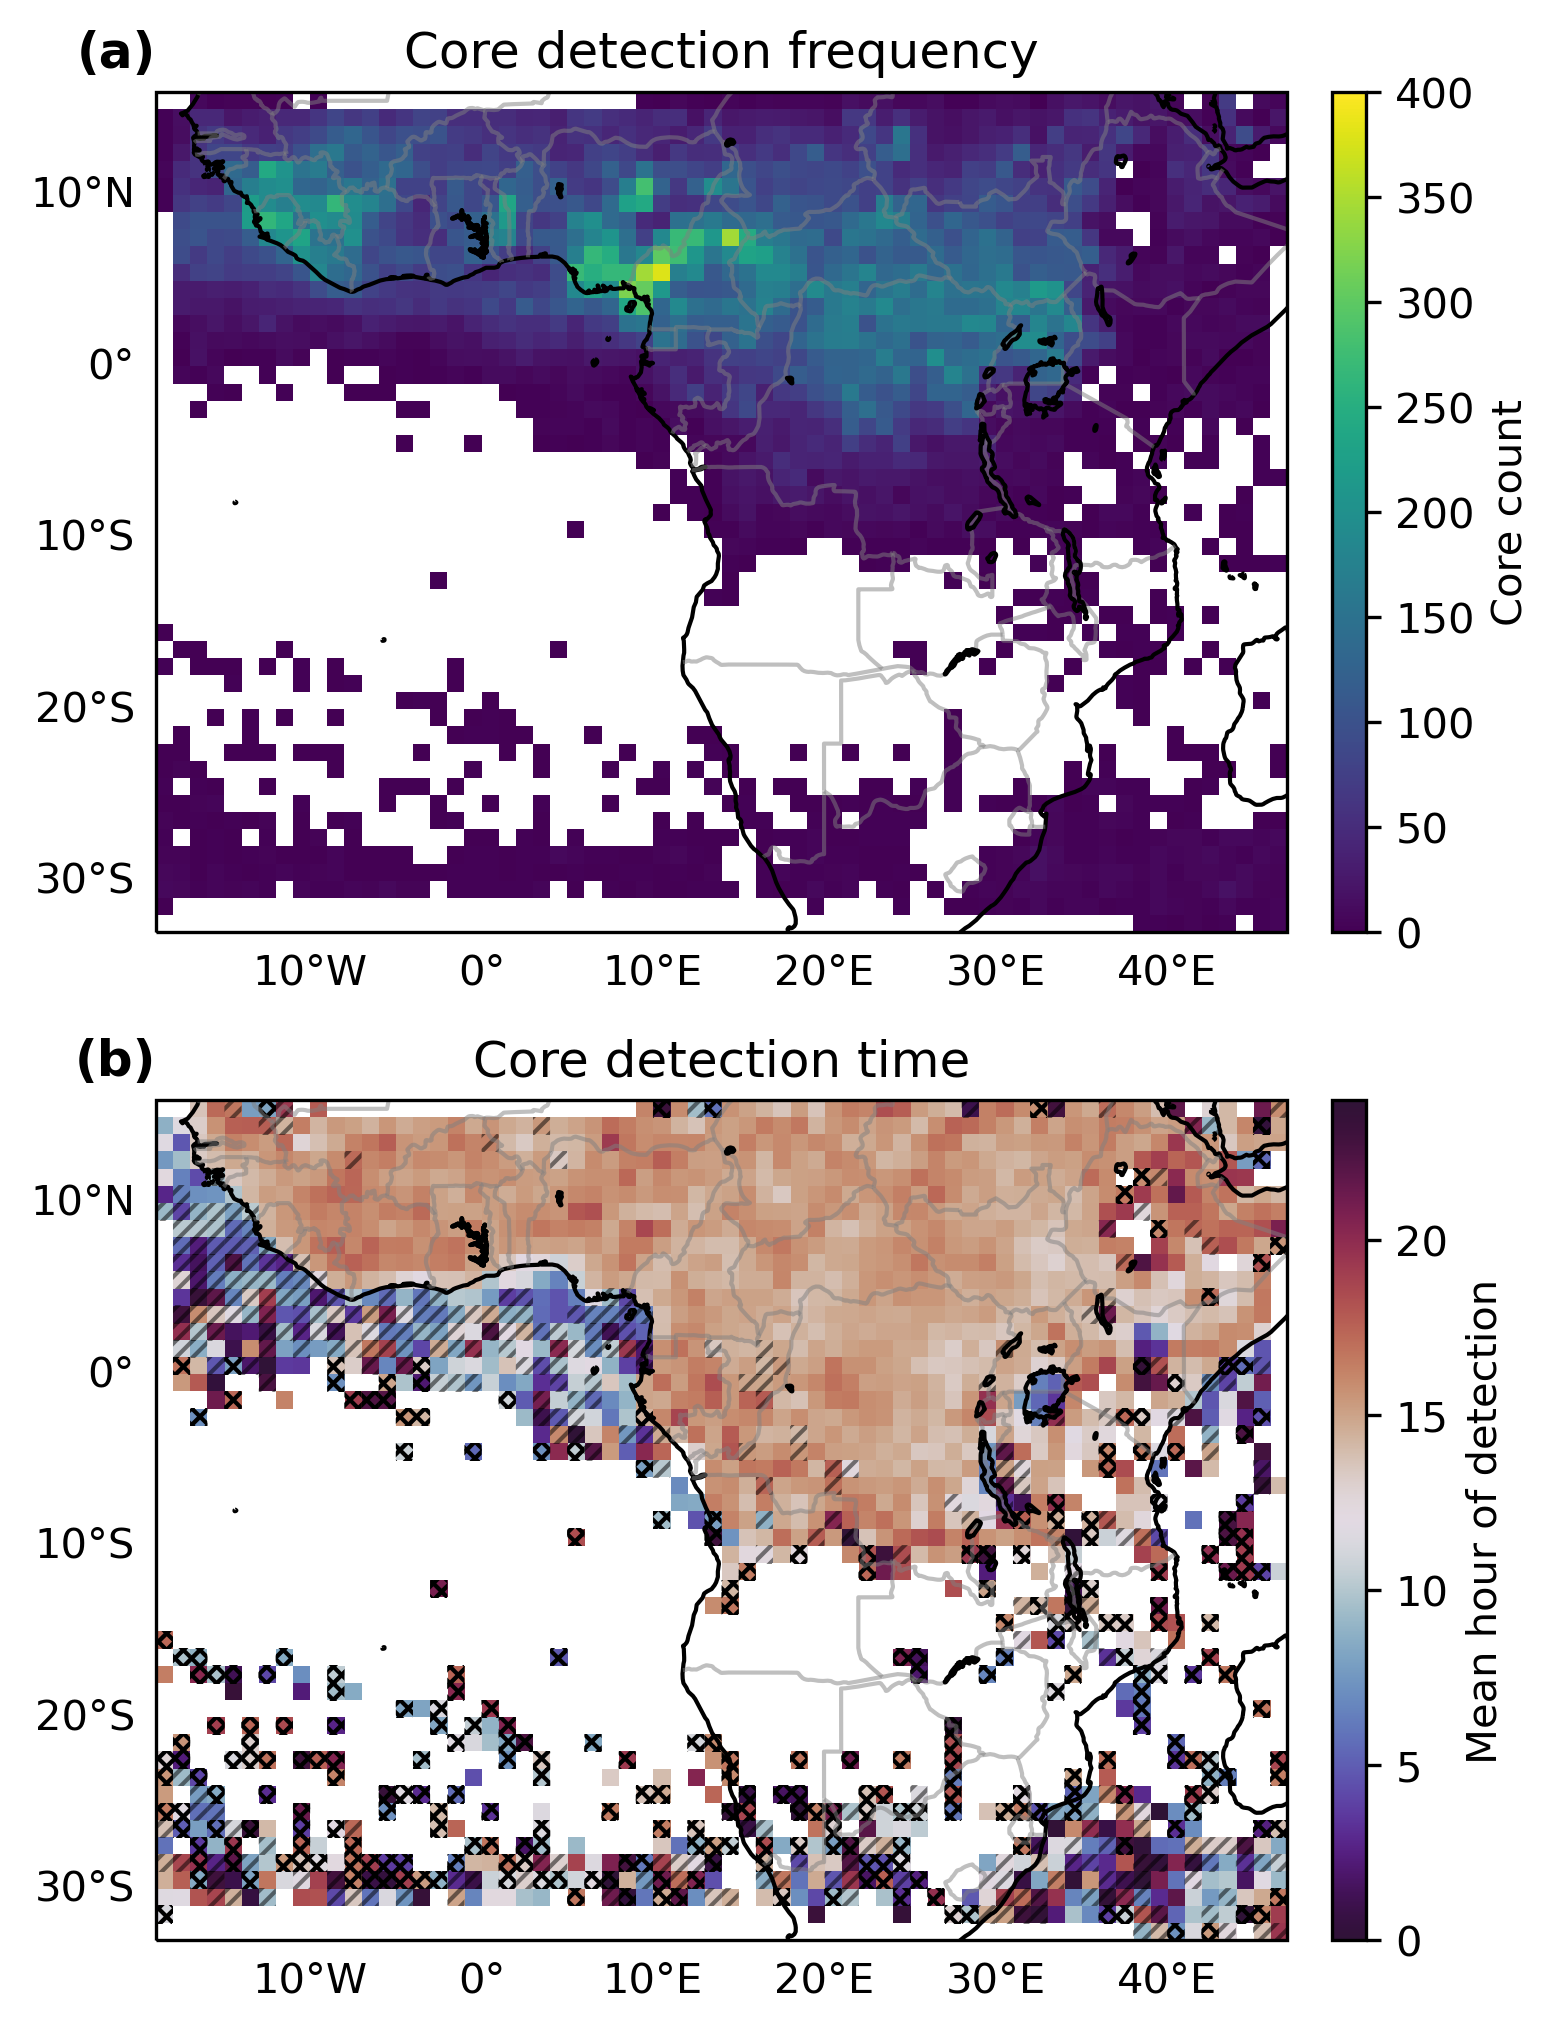

In [43]:
img_extent = (-19, 47, -33, 16)
max_count = 400
min_count = 0

fig = plt.figure(dpi=300, figsize=(6,8))

ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

h = ax1.hist2d(
    core_start_lon, core_start_lat, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
    cmin=1, vmax=max_count, vmin=min_count
)

cbar_size="3%"
cbar_pad=0.15
ax_divider = make_axes_locatable(ax1)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
plt.colorbar(h[3], cax=cax_r, label="Core count")

ax1.set_title("(a)", loc="left", ha="right", weight="bold")
ax1.set_title("Core detection frequency", fontsize=12)

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax2.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
ax2.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

img_data = binned_statistic_2d(
    core_start_lon, core_start_lat, core_local_hour, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), 
          np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circmean_hour
)

img = ax2.imshow(
    img_data[0].T[::-1], extent=img_extent, 
    vmin=0, vmax=24, cmap="twilight_shifted"
)

hatch_data = binned_statistic_2d(
    core_start_lon, core_start_lat, core_local_hour, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), 
          np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circstd_hour
)[0] * (h[0]/(h[0]-1))

for i in range(hatch_data.shape[0]):
    for j in range(hatch_data.shape[1]):
        if np.isfinite(img_data[0][i,j]):
            if np.isfinite(img_data[0][i,j]):
                if hatch_data[i,j] > 6 or np.isnan(hatch_data[i,j]):
                    ax2.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                       hatch='//////', fill=False, snap=False, linewidth=0, alpha=0.5))
                if hatch_data[i,j] > 12 or np.isnan(hatch_data[i,j]):
                    ax2.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                       hatch='//////', fill=False, snap=False, linewidth=0))
                    ax2.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                       hatch="\\\\\\\\\\\\", fill=False, snap=False, linewidth=0))

ax_divider = make_axes_locatable(ax2)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Core count")
cbar.set_label("Mean hour of detection", fontsize=10)

ax2.set_title("(b)", loc="left", ha="right", weight="bold")
ax2.set_title("Core detection time", fontsize=12)

In [22]:
# Now set anvil_is_valid to only contain anvils north of 15S
anvil_is_valid = np.logical_and(anvil_is_valid, anvil_start_lat>-15)

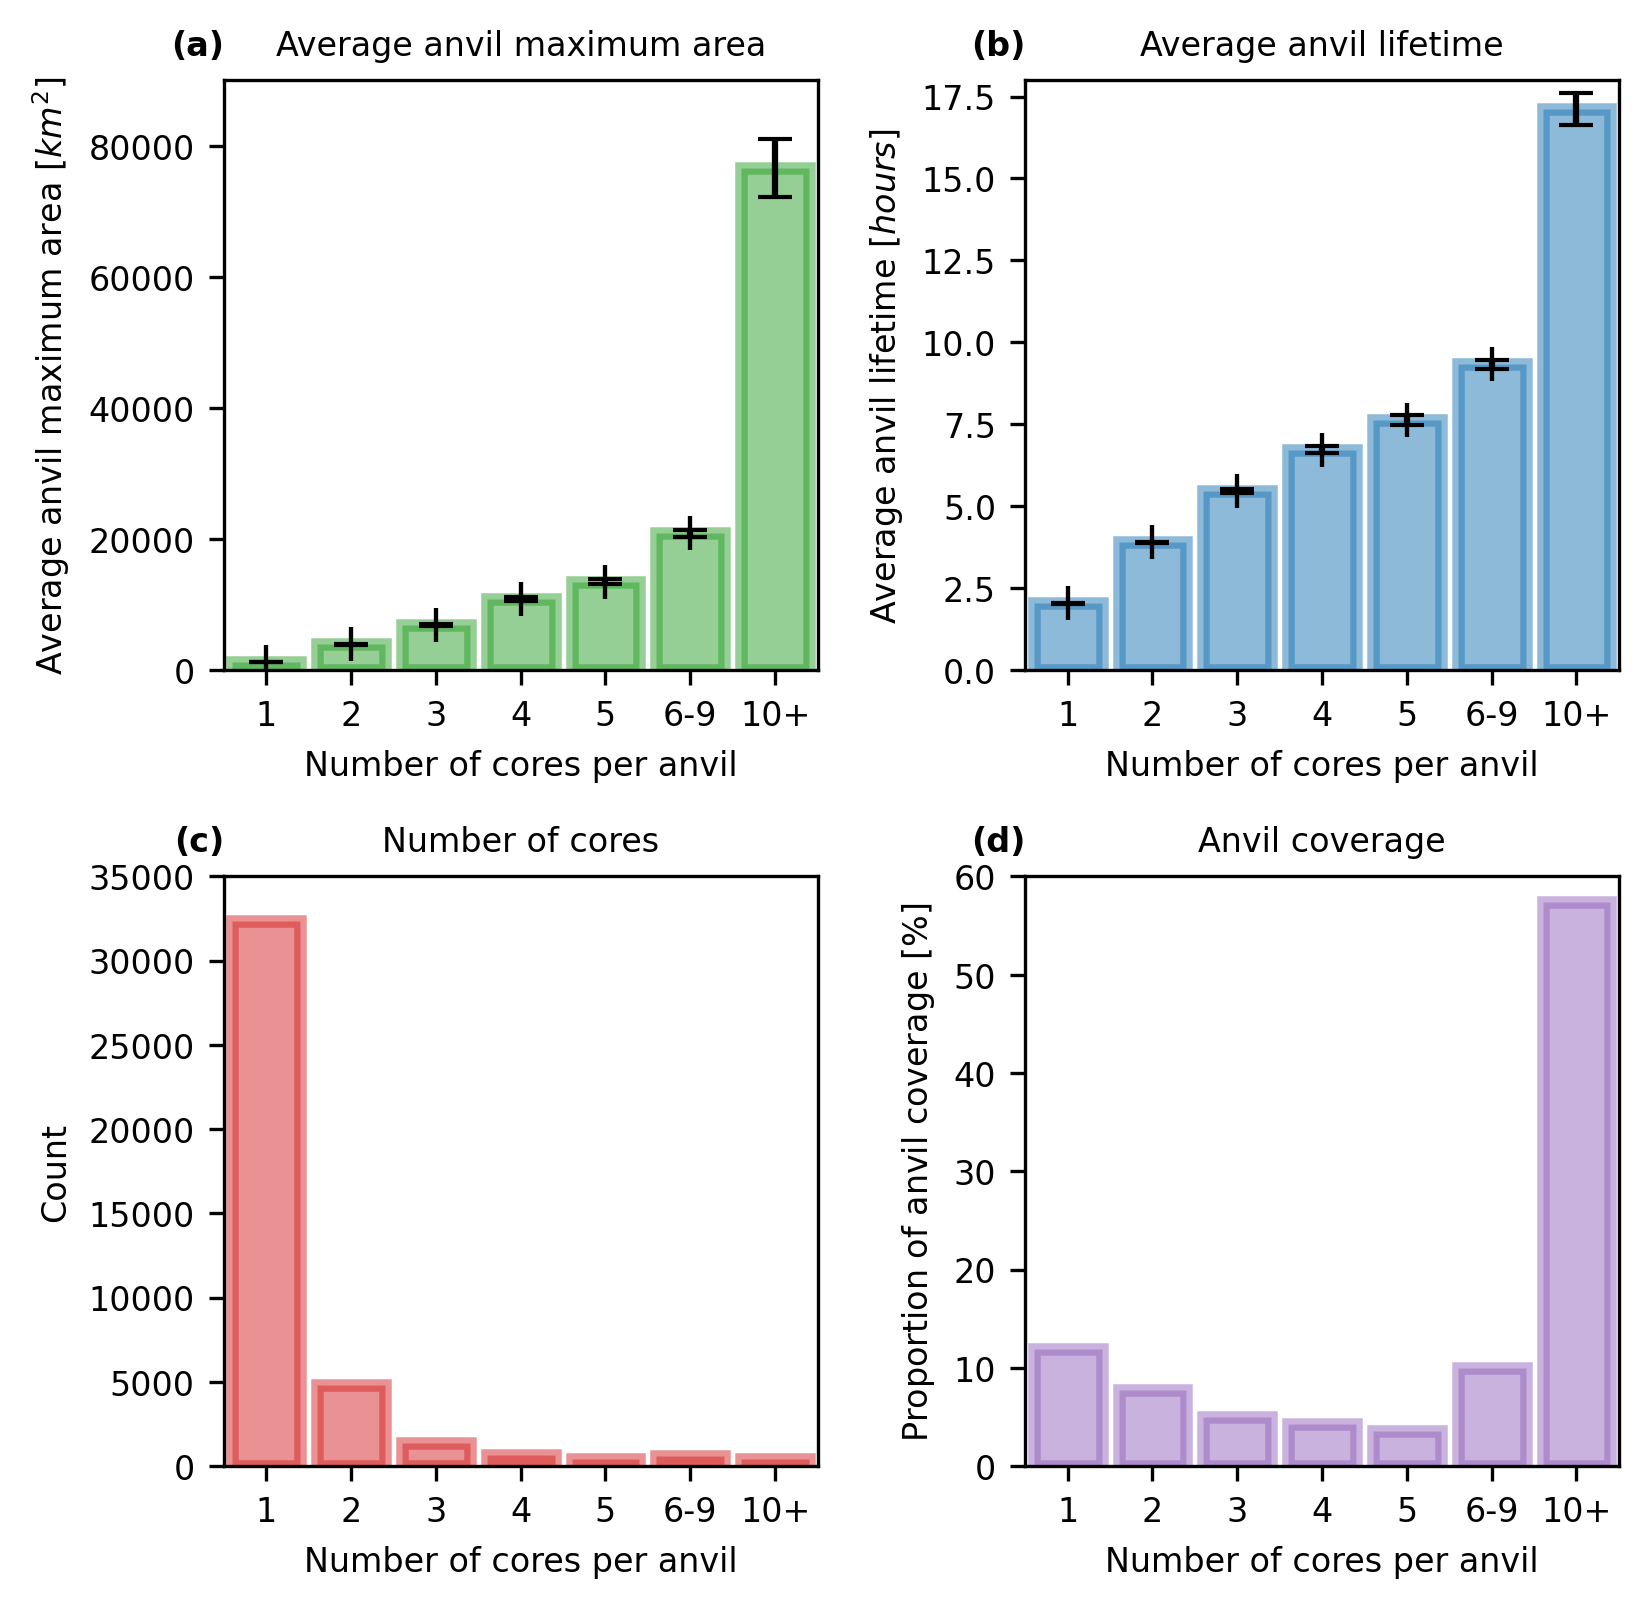

In [55]:
fig = plt.figure(dpi=300, figsize=(6,6))

ax1 = plt.subplot(221)

anvil_max_area = np.concatenate([ds.thick_anvil_max_area.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([0,90000])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil maximum area [$km^2$]", fontsize=8)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)
ax1.set_title("Average anvil maximum area", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax2 = plt.subplot(222)

anvil_lifetime = np.concatenate([ds.thick_anvil_lifetime.data for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([0,18])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil lifetime [$hours$]", fontsize=8)
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)
ax2.set_title("Average anvil lifetime", fontsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

ax3 = plt.subplot(223)

anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.ones(anvil_number_of_cores.size)[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

ax3.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3)

plt.xlim([0.5, 7.5])
plt.ylim([0,35000])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Count", fontsize=8)
ax3.set_title("(c)", loc="left", ha="right", weight="bold", fontsize=8)
ax3.set_title("Number of cores", fontsize=8)
ax3.tick_params(axis='both', which='major', labelsize=8)

ax4 = plt.subplot(224)

anvil_total_area = np.concatenate([ds.thick_anvil_total_area.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_total_area[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.bar(bin_positions, bar_data[0]/np.sum(bar_data[0])*100, 
        alpha=0.5, facecolor = 'C4', edgecolor='C4', ls='solid', lw=3)

plt.xlim([0.5,7.5])
plt.ylim([0,60])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Proportion of anvil coverage [$\%$]", fontsize=8)
ax4.set_title("(d)", loc="left", ha="right", weight="bold", fontsize=8)
ax4.set_title("Anvil coverage", fontsize=8)
ax4.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.35, wspace=0.35)

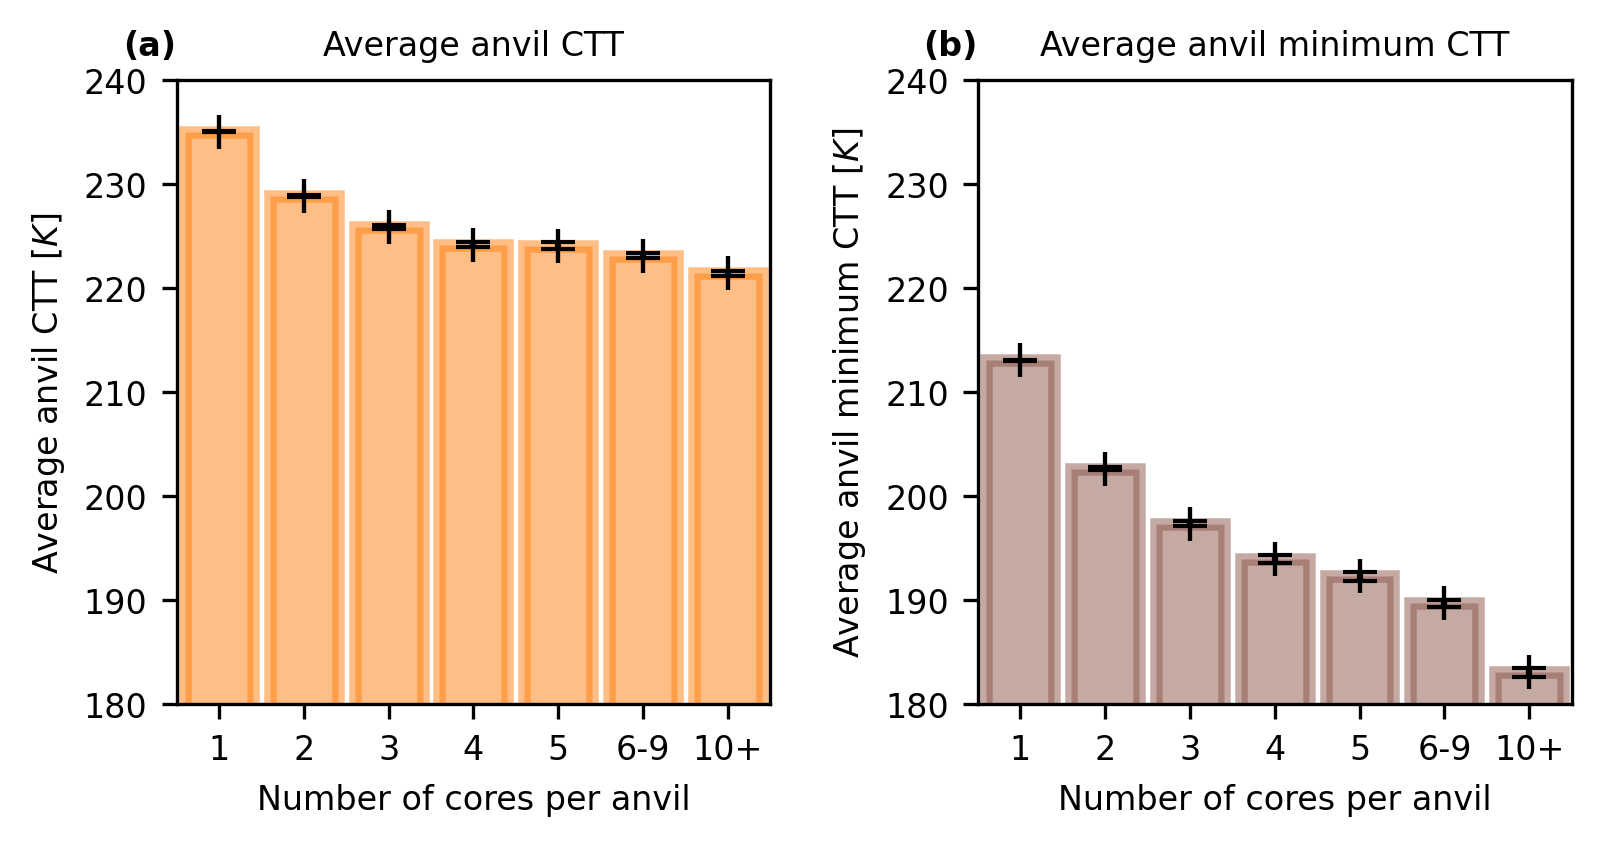

In [52]:
fig = plt.figure(dpi=300, figsize=(6,2.7))

ctt_mean = np.concatenate([ds.thick_anvil_ctt_mean.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_mean[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_mean[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

ax1 = plt.subplot(121)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C1', edgecolor='C1', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([180,240])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil CTT [$K$]", fontsize=8)
ax1.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)
ax1.set_title("Average anvil CTT", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)

ctt_min = np.concatenate([ds.thick_anvil_ctt_min.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_min[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_min[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

ax2 = plt.subplot(122)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C5', edgecolor='C5', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([180,240])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=8)
plt.ylabel("Average anvil minimum CTT [$K$]", fontsize=8)
ax2.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)
ax2.set_title("Average anvil minimum CTT", fontsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(hspace=0.35, wspace=0.35)

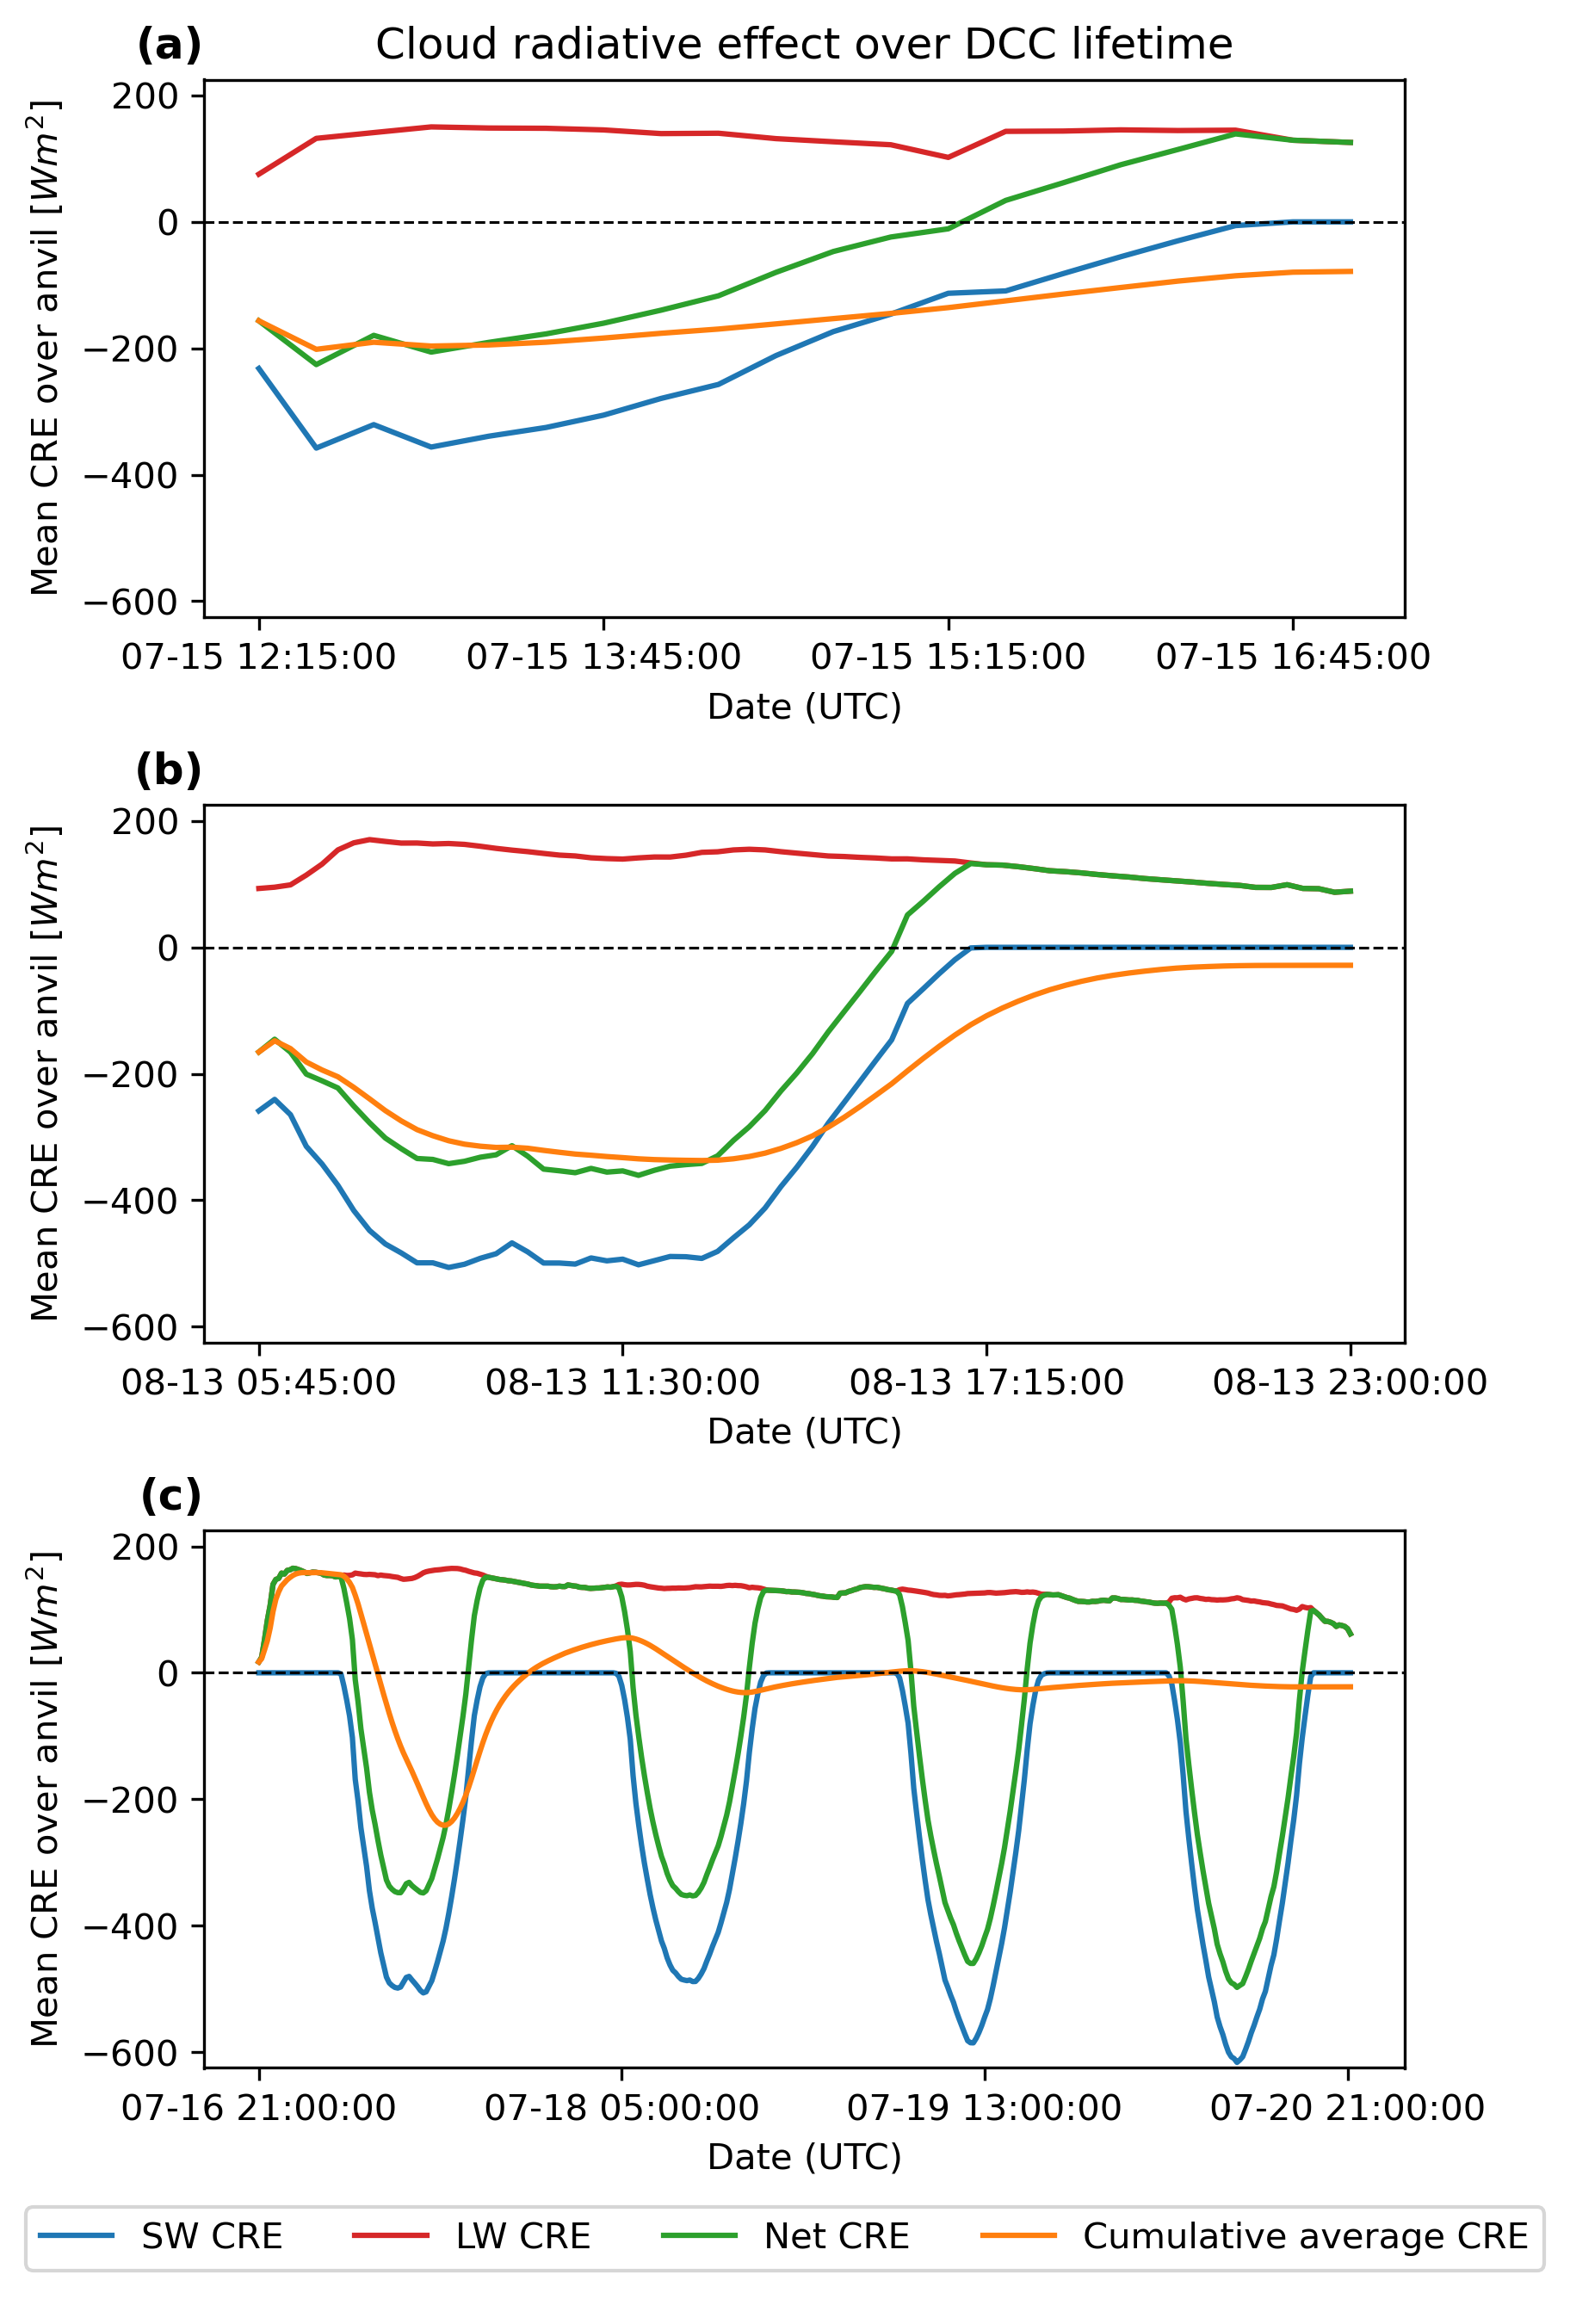

In [67]:
fig = plt.figure(dpi=300, figsize=(6,10))

dataset = datasets[2]
anvil = 14680
# core = np.where(wh_core_step = dataset.core_step_core_index.data==core)+1
# wh_core_step = dataset.core_step_core_index.data==core
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil



ax = plt.subplot(311)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

# plt.legend(["SW CRE", "LW CRE", "Net CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

ax.set_title("(a)", loc="left", ha="right", weight="bold")
ax.set_title('Cloud radiative effect over DCC lifetime')

dataset = datasets[3]
anvil = 9871
# core = np.where(dataset.core_anvil_index.data==anvil)+1
# wh_core_step = dataset.core_step_core_index.data==core
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil


ax = plt.subplot(312)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

# plt.legend(["SW CRE", "LW CRE", "ToA CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

ax.set_title("(b)", loc="left", ha="right", weight="bold")
# plt.title('Cloud radiative effect over DCC lifetime')

dataset = datasets[2]
anvil = 16125
# core = np.where(dataset.core_anvil_index.data==anvil)+1
# wh_core_step = dataset.core_step_core_index.data==core
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil



ax = plt.subplot(313)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

# plt.legend(["SW CRE", "LW CRE", "Net CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

ax.set_title("(c)", loc="left", ha="right", weight="bold")
# plt.title('Cloud radiative effect over DCC lifetime')
plt.subplots_adjust(hspace=0.35)
fig.legend(
    ["SW CRE", "LW CRE", "Net CRE", "Cumulative average CRE"], 
    loc="lower center", ncols=4, borderaxespad=1.5
)


Text(0.5, 1.0, 'Mean CRE distribution [Average: -8.17±0.85 $Wm^{-2}$]')

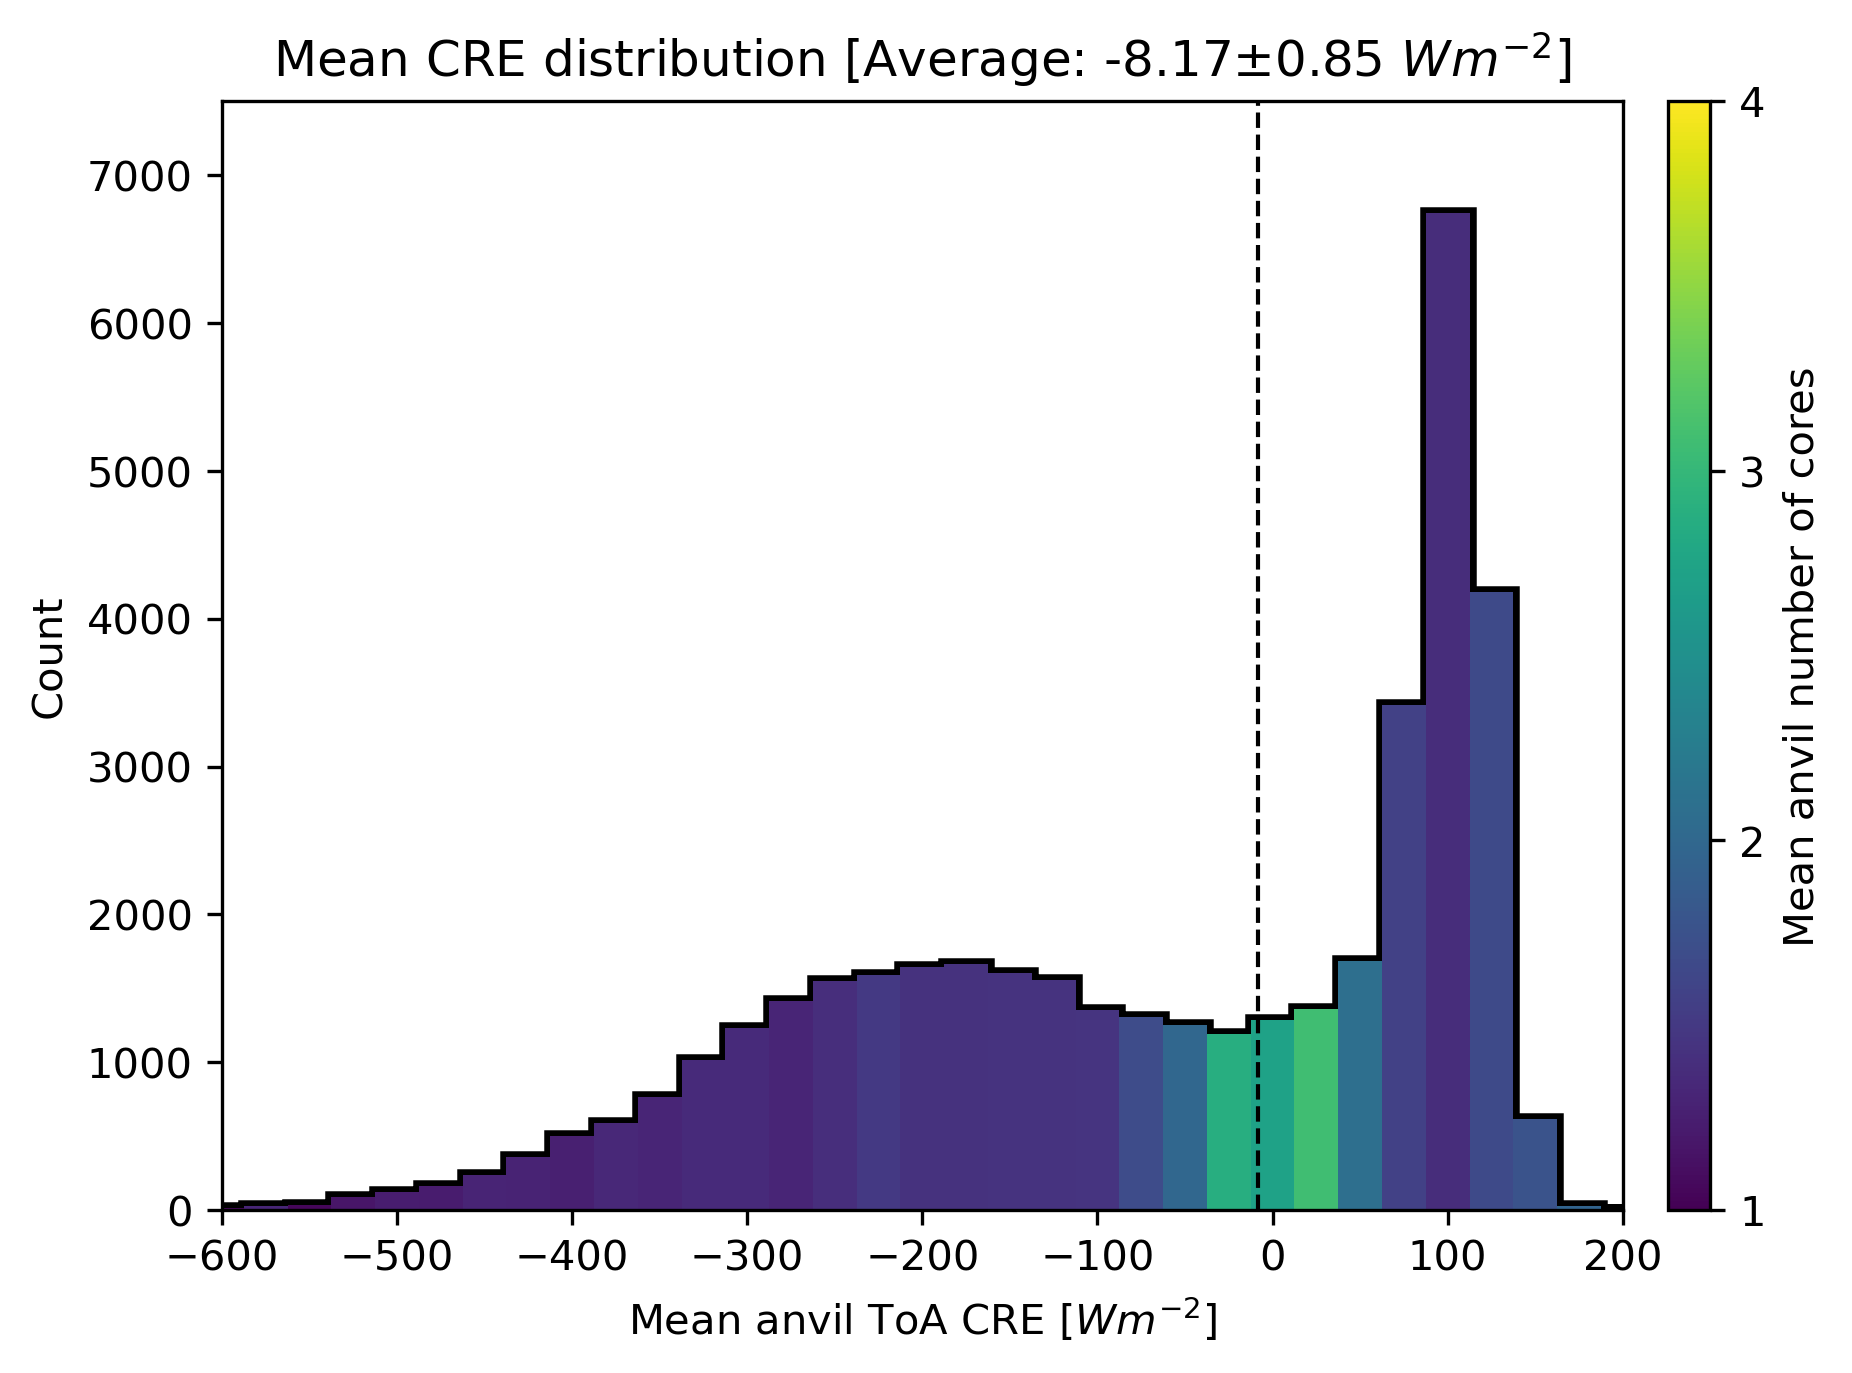

In [113]:
net_cre = np.concatenate([ds.thick_anvil_toa_cre_mean.data for ds in datasets])

fig = plt.figure(dpi=300)
ax = plt.subplot(111)

plt.hist(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=1, facecolor = 'none', edgecolor='black', ls='solid', lw=3, histtype='stepfilled')

bar_data = np.histogram(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0]
bar_color = binned_statistic(
    net_cre[anvil_is_valid], 
    anvil_number_of_cores[anvil_is_valid], 
    bins=np.arange(-600,226,25)-12.5, 
    statistic="mean"
)[0]

bar = plt.bar(
    np.arange(-600,225,25), bar_data, width=25,  
    alpha=1, color = plt.cm.viridis((bar_color-1)/3), edgecolor='none'
)

plt.xlim([-600,200])
plt.xlabel("Mean anvil ToA CRE [$Wm^{-2}$]", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.ylim([0,7500])


cbar_size="3%"
cbar_pad=0.15

img = plt.imshow(np.array([[1,4]]), aspect="auto")
img.set_visible(False)
ax_divider = make_axes_locatable(ax)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean anvil number of cores")
cbar.set_ticks([1,2,3,4])

mean_cre = np.average(net_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(net_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)

# ax.set_title("(a)", loc="left", ha="right", weight="bold")
ax.set_title("Mean CRE distribution [Average: %s±%s $Wm^{-2}$]" % (str(np.round(mean_cre, 2)), str(np.round(mean_error, 2))))

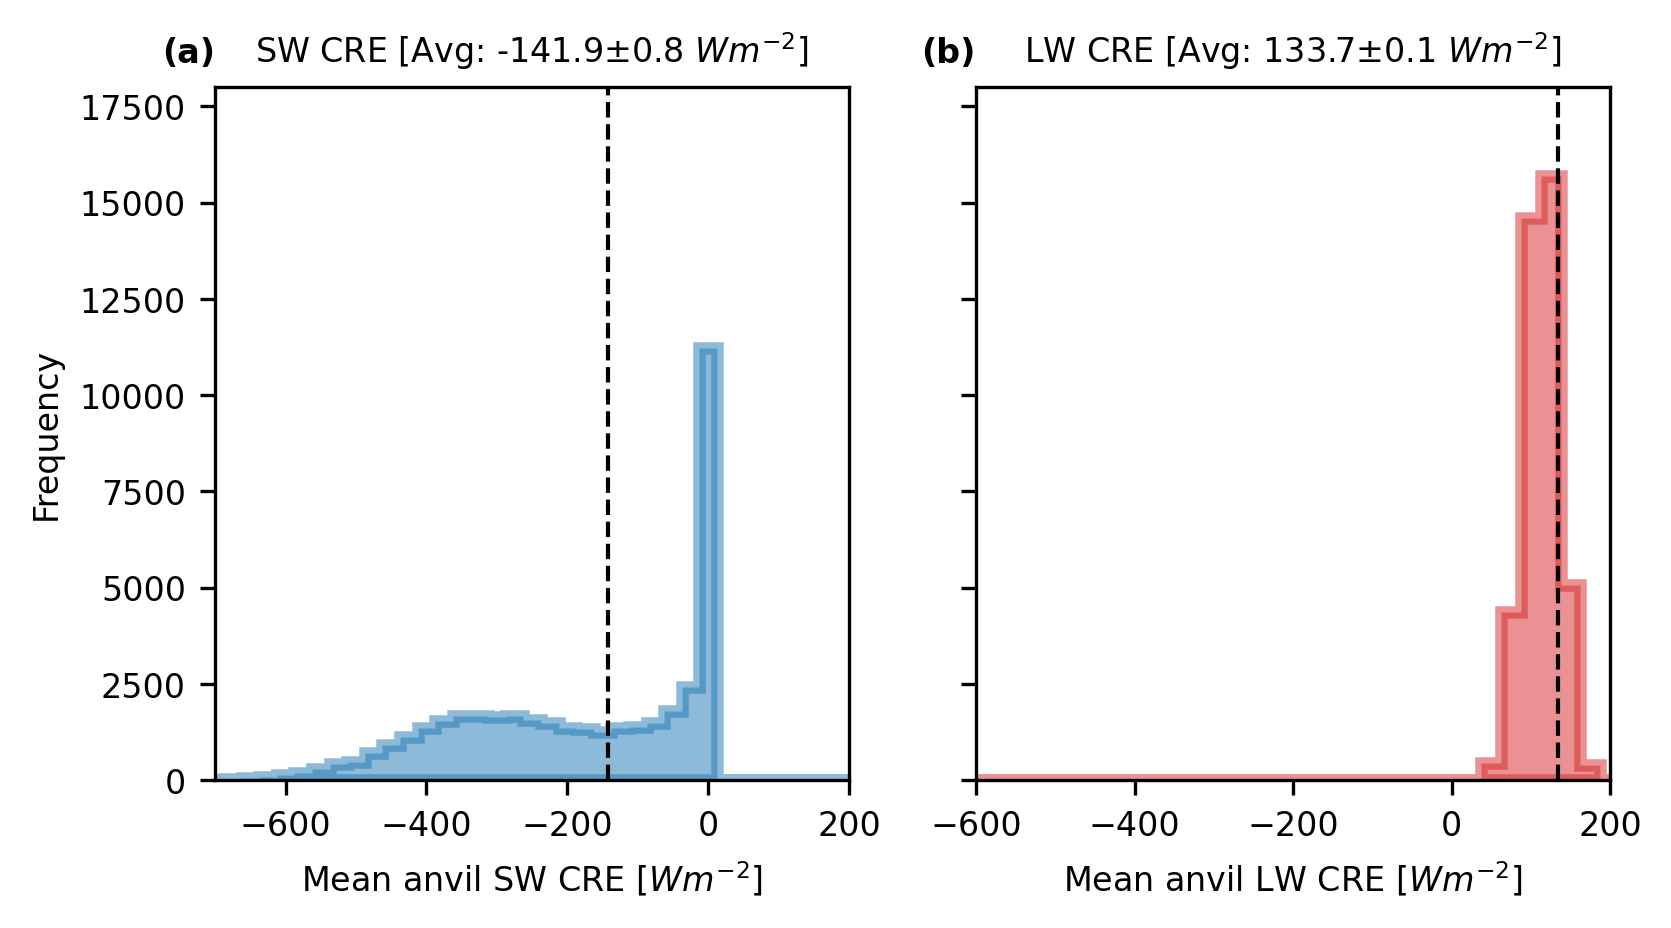

In [117]:
sw_cre = np.concatenate([-ds.thick_anvil_toa_swup_cre_mean.data for ds in datasets])

plt.figure(dpi=300, figsize=(6,3))
ax = plt.subplot(121)
plt.hist(sw_cre[anvil_is_valid], bins=np.arange(-700,226,25)-12.5,  
         alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-700,200])
plt.xlabel("Mean anvil SW CRE [$Wm^{-2}$]", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.yticks(range(0,18000,2500))
ax.tick_params(axis='both', which='major', labelsize=8)
plt.ylim([0,18000])
mean_cre = np.average(sw_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(sw_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.set_title("SW CRE [Avg: %s±%s $Wm^{-2}$]" % (str(np.round(mean_cre, 1)), str(np.round(mean_error, 1))), fontsize=8)
ax.set_title("(a)", loc="left", ha="right", weight="bold", fontsize=8)

ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)

lw_cre = np.concatenate([-ds.thick_anvil_toa_lwup_cre_mean.data for ds in datasets])

ax = plt.subplot(122)
plt.hist(lw_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-600,200])
plt.xlabel("Mean anvil LW CRE [$Wm^{-2}$]", fontsize=8)
# plt.ylabel("Frequency", fontsize=12)
plt.yticks(range(0,18000,2500), [""]*8)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.ylim([0,18000])
mean_cre = np.average(lw_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(lw_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.set_title("LW CRE [Avg: %s±%s $Wm^{-2}$]" % (str(np.round(mean_cre, 1)), str(np.round(mean_error, 1))), fontsize=8)
ax.set_title("(b)", loc="left", ha="right", weight="bold", fontsize=8)

ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)


Text(0.5, 1.0, 'Average anvil CRE')

<Figure size 1920x1440 with 0 Axes>

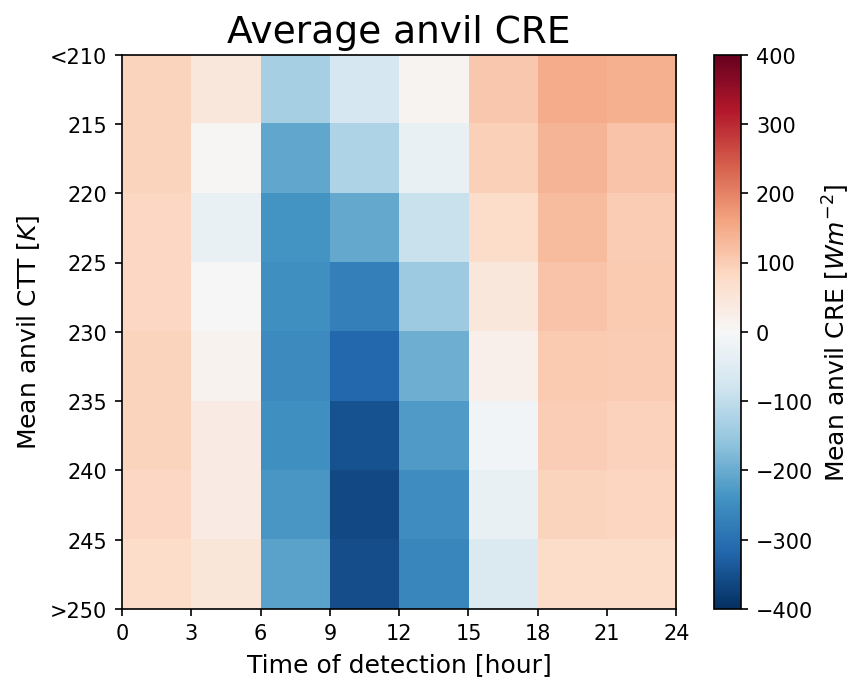

In [120]:
ctt_mean = np.concatenate([ds.thick_anvil_ctt_mean.data for ds in datasets])

ctt_bins = [190,215,220,225,230,235,240,245,270]
time_bins = [0,3,6,9,12,15,18,21,24]

ctt_labels = ["<210",215,220,225,230,235,240,245,">250"]

fig = plt.figure(dpi=300)

img_data = binned_statistic_2d(
    ctt_mean[anvil_is_valid], 
    anvil_local_hour[anvil_is_valid], 
    net_cre[anvil_is_valid], 
    bins=[ctt_bins, time_bins]
)[0]

plt.figure(dpi=150)
plt.imshow(img_data, cmap="RdBu_r", vmin=-400, vmax=400)
cbar = plt.colorbar()
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.xticks(np.arange(len(time_bins))-0.5, time_bins)
plt.xlabel("Time of detection [hour]", fontsize=12)
plt.yticks(np.arange(len(ctt_bins))-0.5, ctt_labels)
plt.ylabel("Mean anvil CTT [$K$]", fontsize=12)

plt.title("Average anvil CRE", fontsize=18)